In [1]:
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Utils as utils
import seaborn as sns
import warnings
from sklearn import ensemble
from sklearn import multioutput
from sklearn.preprocessing import OrdinalEncoder
import joblib

c:\Users\HAMZA\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


## Warnings

In [2]:
# For output settings
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 700)

# For warnings
warnings.filterwarnings("ignore")

## Load Dataset

In [3]:
train_df = pd.read_parquet("train_final.parquet")
test = pd.read_parquet("test_final.parquet")


In [4]:
print(train_df['id'].unique())

['5beefd4d2bf4a4767e0df8108' '867285b116c063d5a8482f5be'
 'c82a7cbd2e00d9b66c06bcadc' ... 'fa842185a0edd210845b78308'
 'db8f55b8499f8d8c05148240e' '93c3b8ecbb3071cf0a925a860']


## Target

In [5]:
def do_Target_spareted(dataframe):
    new_spareted_cabin = dataframe["target"].str.split(pat = ",", expand = True)
    
    dataframe.drop("target", axis=1, inplace=True)
    
    new_spareted_cabin.rename(columns={0 : 'first_menu',
                                       1 : 'second_menu',
                                       2 : 'third_menu'}, inplace=True)
    
    return pd.concat([dataframe, new_spareted_cabin], axis=1)

def binarize_column(column):
    lb = LabelBinarizer()
    transformed_data = lb.fit_transform(column)
    if column.name == "second_menu":
        transformed_data = [np.insert(row, 4, 0) for row in transformed_data]
    elif column.name == "third_menu":
        transformed_data = [np.insert(row, 2, 0) for row in transformed_data]
    return pd.Series([row.tolist() for row in transformed_data])

In [6]:
train_df = do_Target_spareted(train_df)

train_df["first_menu"] = binarize_column(train_df["first_menu"])
train_df["second_menu"] = binarize_column(train_df["second_menu"])
train_df["third_menu"] = binarize_column(train_df["third_menu"])

train_df['target'] = train_df[['first_menu', 'second_menu', 'third_menu']].apply(
    lambda row: [1 if any(x) else 0 for x in zip(*row)], axis=1
)

train_df.drop(["first_menu","second_menu","third_menu"], inplace=True, axis=1)

In [7]:
def dataprep1(df):
    # df['group_Count'] = df.groupby('id')['id'].transform('count')-1
    # DROP ID
    df.drop('id',axis=1,inplace=True)
    
    # DEVICEBRAND
    df['devicebrand'] = df['devicebrand'].str.upper()
    df['devicebrand'] = df['devicebrand'].str.replace('GM', 'GENERALMOBILE', regex=True)
    
    # CARRIER
    df['carrier'] = df['carrier'].apply(lambda x: 'VODAFONE' if 'VODAFONE' in x else x)
    df['carrier'] = df['carrier'].apply(lambda x: 'VODAFONE' if 'VF' in x else x)
    df['carrier'] = df['carrier'].apply(lambda x: 'TURKCELL' if 'LIFECELL' in x else x)
    for i in ['TURK TELEKO','TÜRK TELEKO','TURKTELEKOM']:
        df['carrier'] = df['carrier'].apply(lambda x: 'TURK_TELEKOM' if i in x else x)
    df['carrier'] = df['carrier'].str.replace('^KCELL ', 'AKCELL', regex=True)
    df['carrier'] = df['carrier'].str.replace('^中国', 'CHINATEL', regex=True)
    df['carrier'] = df['carrier'].str.replace('ドコモ', 'JAPENTEL', regex=True)  
    df['carrier'] = df['carrier'].str.replace('^Z 4.5G+', 'ZAIN', regex=True)  


    yurtdisi = ['ALMADAR','AIRTEL','AZERCELL','BAKCELL','O2','BEE','A1 ','3_AT','IRANCELL',
                'AYYILDIZ','BH','NL','ORANGE','MOLDCELL','ZAIN','YETTEL','VERIZONE','TELEKOM',
                'TELENOR','TELE2','TELIA','MAGTI','STC','BOUYGUES','HORMUUD','JIO','LIDL','KSA',
                'FREEDOM','BUDGET','XFINITY','CHINA_TELECOM','MTN','1&1','BASE','CLARO','GEOCELL',
                'MEGAFONE','GSMOBILE','ETISALAT','TIM','MAXIS','PROXIMUS', 'SUNRISE', 'WINDTRE', 
                'VODACOM', 'LYCAMOBILE','LIBYANA','TIGO', 'ASIACELL', 'SFR','CUBACELL','AKCELL',
                'SALT','T-MOBILE', 'CHINATEL', 'JAPENTEL','ROBI','AWCC','KYIVSTAR','GLOBE','TDC',
                'DIGICEL','DIGITEL','DIGITEC','VOLNA','HANDYVERTRAG'] 
    sirket = ['TURKCELL','BIMCELL','AVEA','VODAFONE','TURK_TELEKOM','TEKNOSA','PTTCELL','KKTCELL','PRIMETEL']
    
    for anahtarKelime in yurtdisi+sirket:
        df['carrier'] = df['carrier'].apply(lambda x: anahtarKelime if anahtarKelime in x else x)
    
    for anahtarKelime in ['HAYAT','FENER','TRABZON','61','UNKNOWN',' ','nknown']:  
        df['carrier'] = df['carrier'].apply(lambda x: 'UNKNOWN' if anahtarKelime in x else x)
        
    # print(df['carrier'].unique())
    # print(df['devicebrand'].unique())
    
    unknown = [row for row in df['carrier'].unique() if row not in yurtdisi+sirket]
    df['carrier'] = df['carrier'].apply(lambda x: 'UNKNOWN' if x in unknown else x if x not in unknown else x)

    # ENCODE
    ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
    df[['carrier', 'devicebrand']] = ordinal_encoder.fit_transform(df[['carrier', 'devicebrand']]) 
    
    # FETURE EXTRACTION
    # df['total_second'] = df['n_seconds_1']+df['n_seconds_2']+df['n_seconds_3']
    
    return df

In [8]:
# def dataprep1(df):
#     # DROP ID
#     df.drop('id',axis=1,inplace=True)
#     df.drop('carrier',axis=1,inplace=True)
    
#     # DEVICEBRAND
#     df['devicebrand'] = df['devicebrand'].str.upper()
#     df['devicebrand'] = df['devicebrand'].str.replace('GM', 'GENERALMOBILE', regex=True)
#     # ENCODE
#     ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
#     df[['devicebrand']] = ordinal_encoder.fit_transform(df[['devicebrand']]) 
    
#     # FETURE EXTRACTION
#     # df['total_second'] = df['n_seconds_1']+df['n_seconds_2']+df['n_seconds_3']
    
#     return df

## TRAIN - TEST

In [9]:
train_df = dataprep1(train_df)
test = dataprep1(test)

## MODELLING

In [10]:
# train_df = train_df.drop_duplicates(subset='id', keep='first')
X = train_df.drop("target", axis=1)
y = train_df["target"]
numpy_dizi = y.to_numpy()
numpy_dizi = [np.array(row) for row in numpy_dizi]

In [11]:
reg = multioutput.MultiOutputRegressor(ensemble.GradientBoostingRegressor())
reg.fit(X, numpy_dizi)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [12]:
y_pred = reg.predict(test)

In [13]:
joblib.dump(reg, "009.pkl")

['009.pkl']

In [14]:
model = joblib.load('009.pkl')
y_pred = model.predict(test)

In [15]:
def sample_sub(ypred):
    

    sample = pd.read_csv("csv_sample.csv")

    submission = pd.DataFrame({"id": sample["id"],
                                "target": ypred})
    submission.to_csv("09.csv", index=False)
    df = pd.read_csv('09.csv')
    df['target'] = df['target'].apply(lambda x: ''.join(map(str, eval(x))))
    df.to_csv('009.csv',index=False)
    df.to_csv('009.csv',index=False)

In [16]:
for row in y_pred:
    list_with_index = [(value, index) for index, value in enumerate(row)]
    sorted_list = sorted(list_with_index, key=lambda x: x[0])
    three_values = [x[1] for x in sorted_list[-3:]]
    row[three_values]=1
    row[~np.isin(np.arange(len(row)), three_values)] = 0
y_pred = y_pred.astype(int)
y_pred = [row.tolist() for row in y_pred]
print(y_pred)

[[0, 1, 0, 0, 0, 1, 1, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 1, 0, 0, 0, 0], [0, 1, 0, 0, 1, 1, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 1, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 1, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 0, 1, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [1, 1, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 0], [0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 1, 0, 1, 

In [17]:
sample_sub(pd.Series(y_pred))

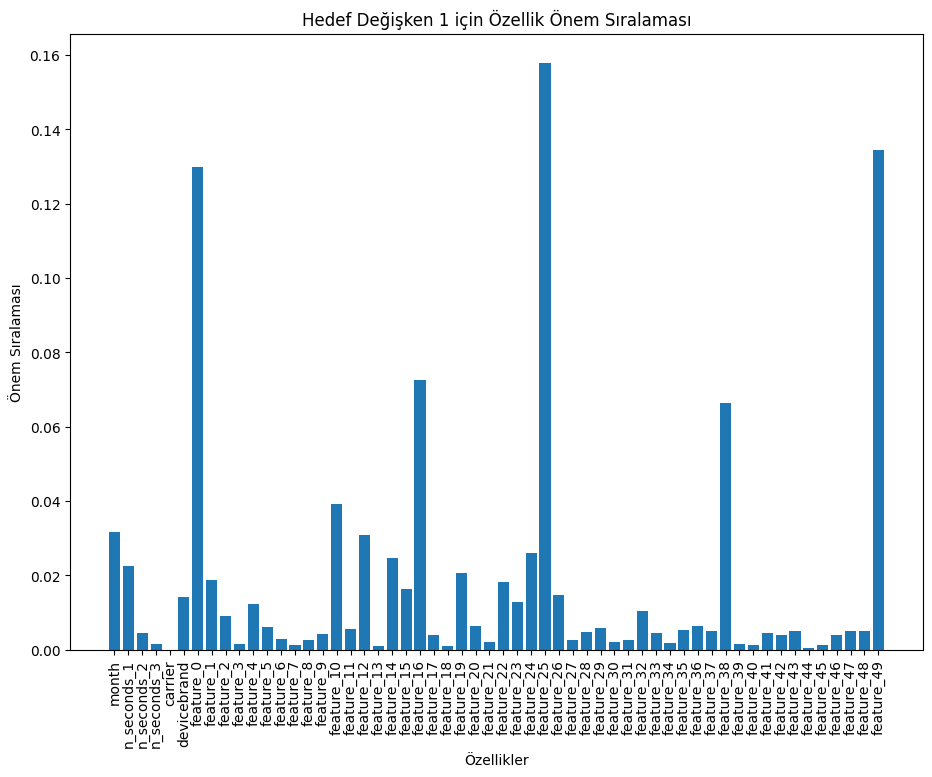

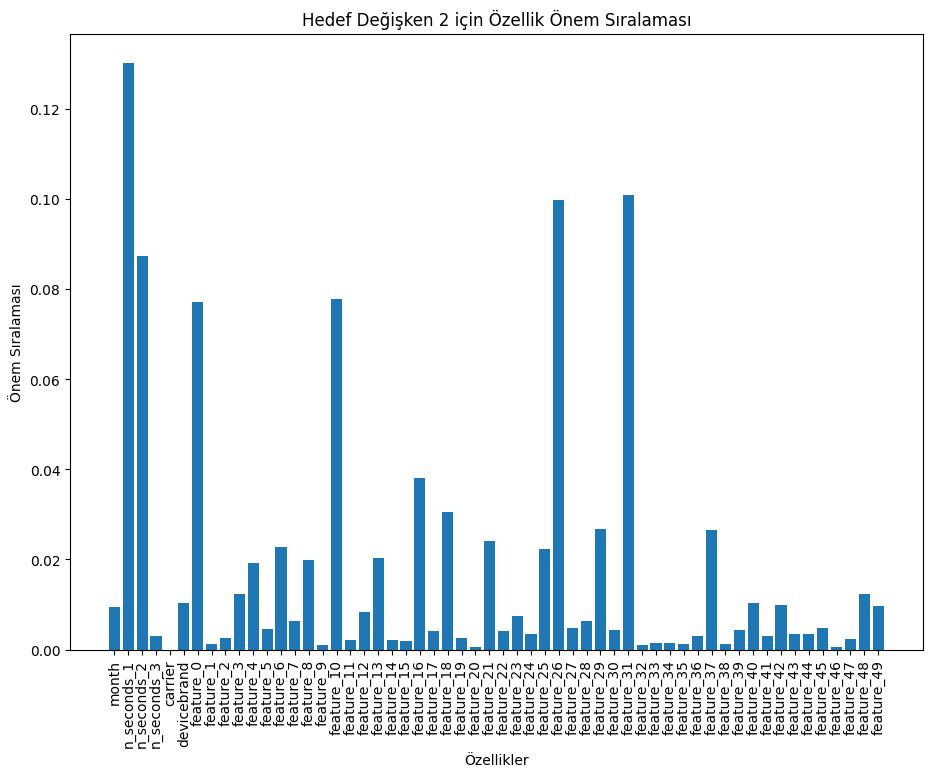

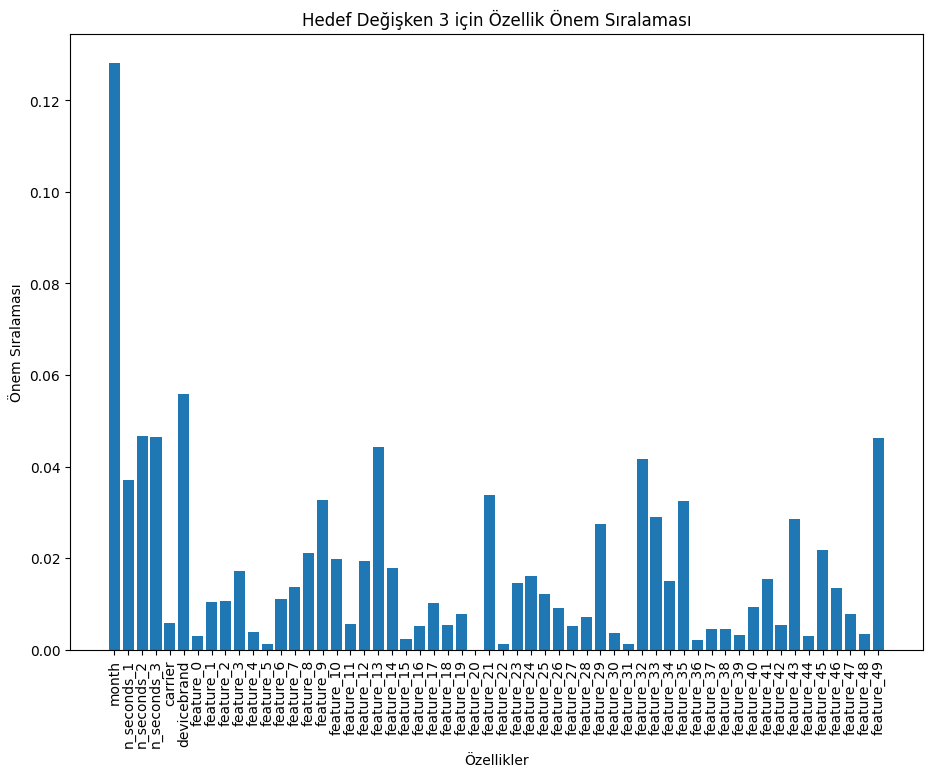

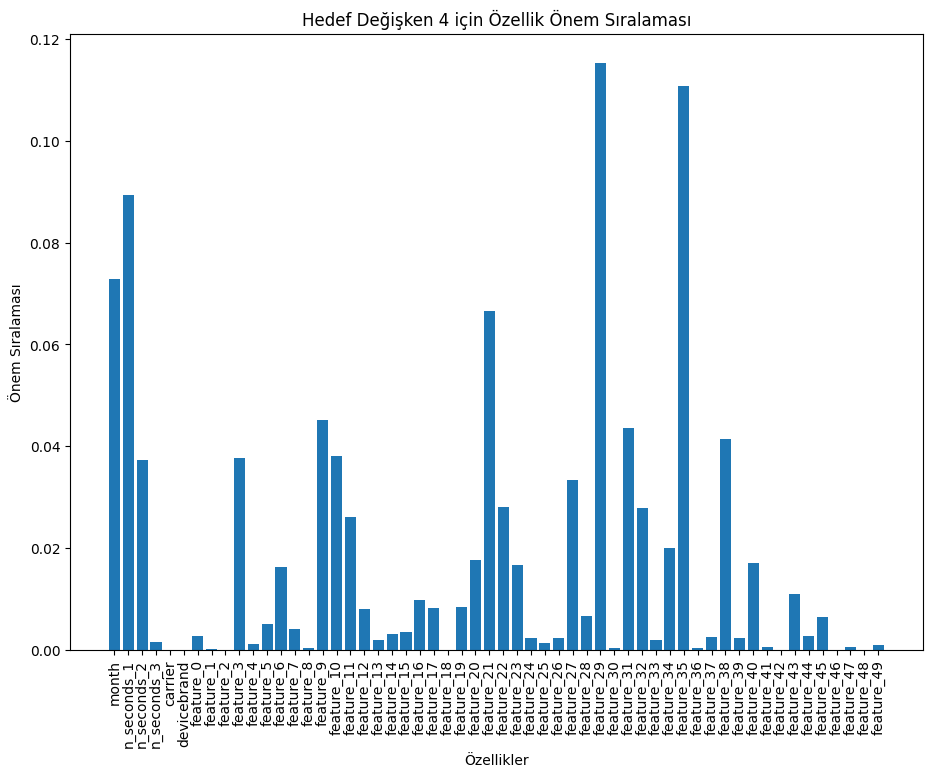

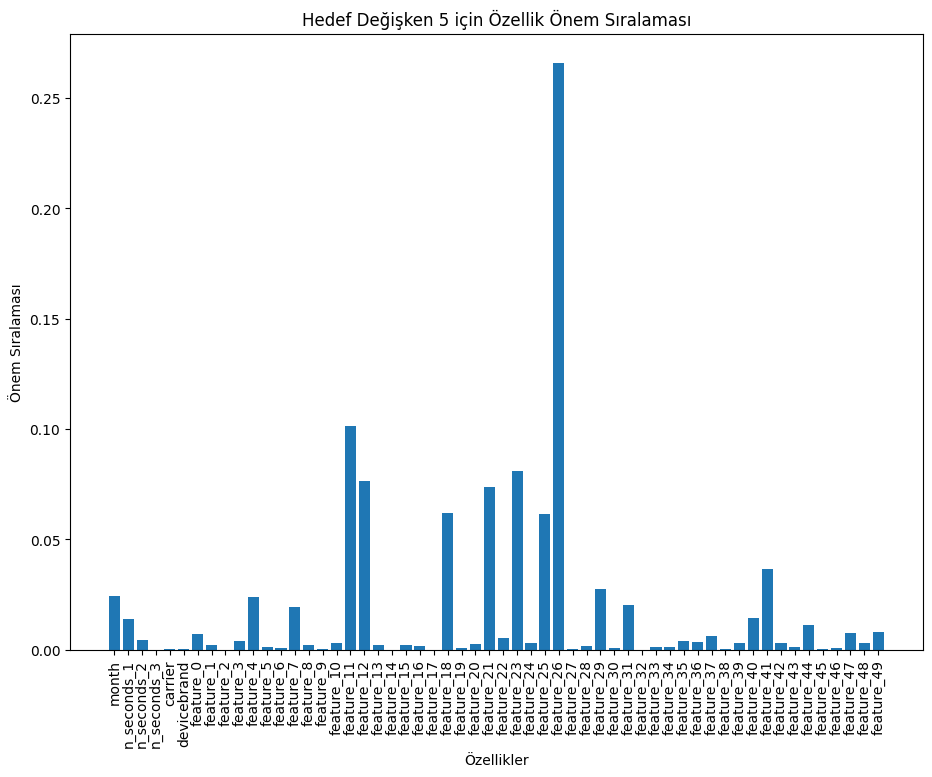

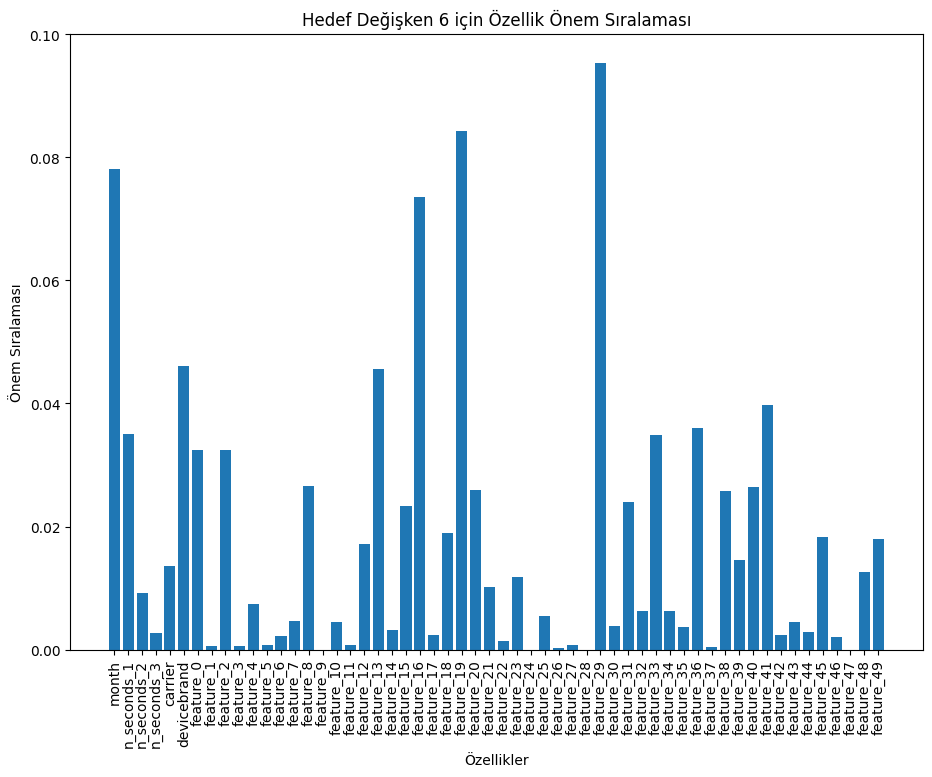

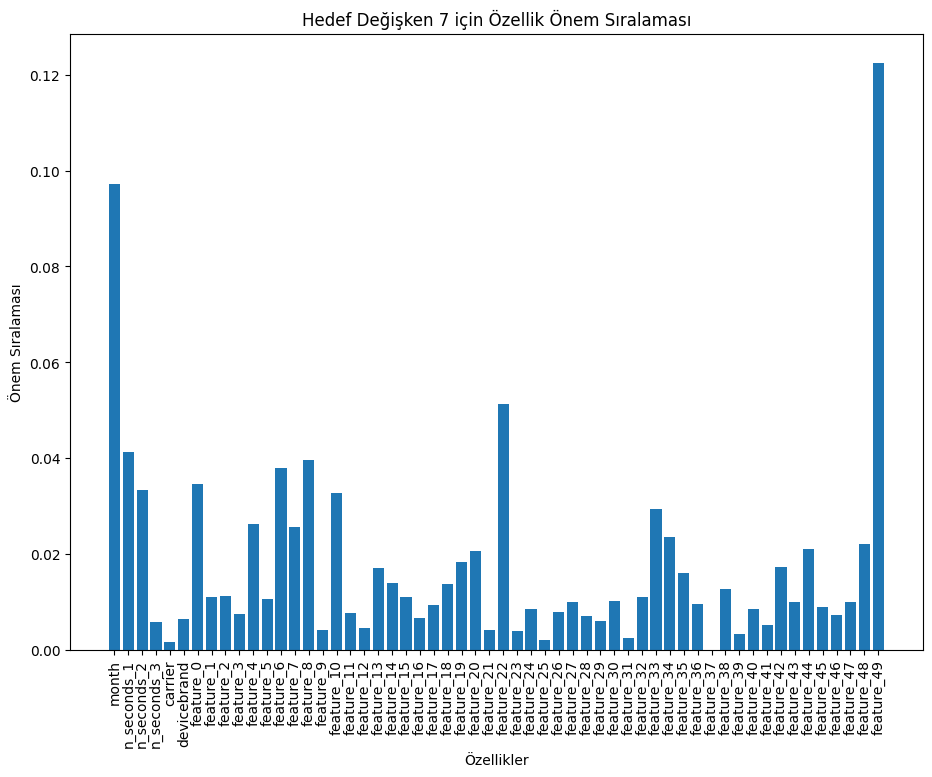

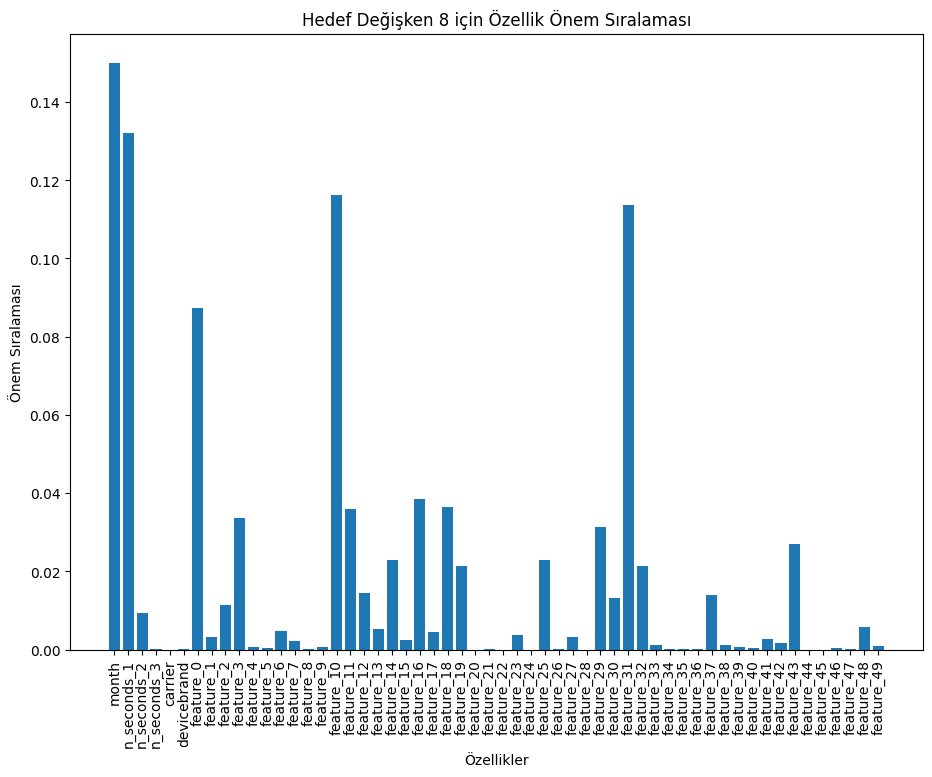

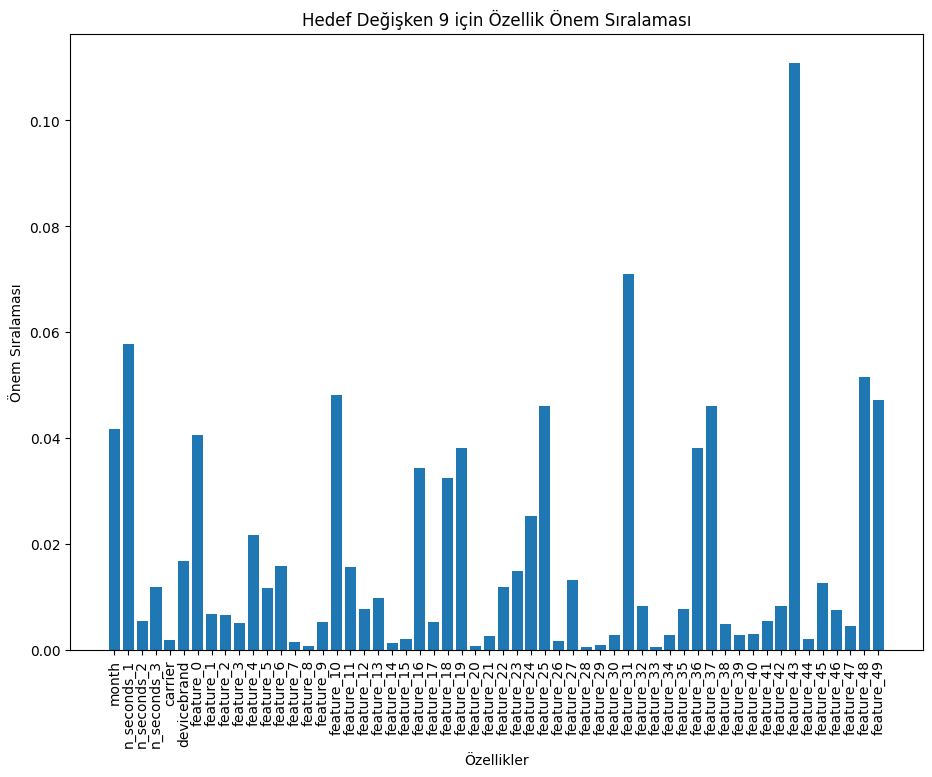

In [18]:
import matplotlib.pyplot as plt

# Her bir hedef değişken için özellik önem sıralamalarını saklayacak bir liste oluşturun
feature_importances = []

for estimator in model.estimators_:
    # Her bir hedef değişken için özellik önem sıralamasını alın
    feature_importance = estimator.feature_importances_
    feature_importances.append(feature_importance)

# Feature importance değerlerini numpy dizisine çevirin
feature_importances = np.array(feature_importances)

# Veri çerçevesinin sütun isimlerini alın (örneğin, X veri çerçevesi için)
sütun_isimleri = X.columns

# Özellik önem sıralamalarını çizin ve sütun isimlerini ekleyin
for i in range(len(feature_importances)):
    plt.figure(figsize=(11, 8))
    plt.bar(range(len(feature_importances[i])), feature_importances[i])
    plt.xlabel('Özellikler')
    plt.ylabel('Önem Sıralaması')
    plt.title(f'Hedef Değişken {i+1} için Özellik Önem Sıralaması')
    x_etiketleri = range(len(sütun_isimleri))
    plt.xticks(x_etiketleri, sütun_isimleri)  # Sütun isimlerini ekleyin
    plt.xticks(rotation=90)  # Sütun isimlerini 90 derece döndürün
    plt.show()


In [19]:
from sklearn.metrics import accuracy_score
y_test = pd.read_csv("csv\zero2.csv")
y_pred = pd.read_csv('009.csv')
accuracy = accuracy_score(y_test["target"], y_pred["target"])

print("Accuracy:", accuracy)

Accuracy: 0.9870347135089921
